In [11]:
# Creating an options base class

class StockOption(object):
    def __init__(self, S0, K, r = 0.05, T = 1, N = 2, pu = 0, pd = 0, div = 0, sigma = 0, is_put = False, is_am = False):
    # S0 = initial stock price
    # K = strike price
    # r = risk-free rate
    # T = time to maturity
    # N = number of time steps
    # pu = probability at up-state
    # pd = probability at down-state
    # div = dividend yield
    # is_put = true for puts, false for calls
    # is_am = true for American option, false for European
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N)
        self.pu = pu
        self.pd = pd
        self.div = div
        self.sigma = sigma
        self.is_call = not is_put
        self.is_european = not is_am
        self.STs = [] # Declares the stock prices tree
        
        
        # Find value of a single time step (in years)
    @property
    def dt(self):
        return self.T/float(self.N)
        
    # Find discount factor
    @property
    def df(self):
        return math.exp(-(self.r - self.div)*self.dt)

In [12]:
import numpy as np
import math
from decimal import Decimal

# make a Euro subclass
class BinomialEuropeanOption(StockOption):
    def setup_parameters(self):
        self.M = self.N+1 # number of terminal nodes in tree
        self.u = 1+self.pu
        self.d = 1-self.pd
        # solve for the risk-neutral probability of investing in the stock
        self.qu = (math.exp((self.r-self.div)*self.dt)-self.d) / (self.u-self.d)
        self.qd = 1-self.qu
        
    def init_stock_price_tree(self):
        # initialize terminal price nodes to 0
        self.STs = np.zeros(self.M)
        
        # calculate expected stock prices for each node
        for i in range(self.M):
            self.STs[i] = self.S0*(self.u**(self.N-i)) * (self.d**i)
        # print('Stock tree is: ', self.STs)
    
    def init_payoffs_tree(self):
        # return payoffs when reaching terminal nodes
        if self.is_call:
            return np.maximum(0, self.STs - self.K)
        else:
            return np.maximum(0, self.K - self.STs)
        
    def traverse_tree(self, payoffs):
        # calculate discounted payoffs at each node
        # print('pre-discounted payoffs are', payoffs)
        # print('discount factor is: ', self.df)
        # print('qu is', self.qu)
        # print('qd is', self.qd)
        
        # starts at terminal nodes - discounts one level at a time weighing by risk neutral probabilities
        for i in range(self.N):
            payoffs = (payoffs[:-1]*self.qu + payoffs[1:]*self.qd)*self.df
            # print('payoffs are', payoffs)
        return payoffs
        
    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.traverse_tree(payoffs)
    
    def price(self):
        # delivers the price of the option
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [13]:
# run an option
eu_option = BinomialEuropeanOption(50, 52, r=0.05, T=4, N=4, pu=0.2, pd=0.2, is_put=True)
eu_option1 = eu_option.price()
print('Euro put option price is: ', eu_option1) 

Euro put option price is:  4.330196749669495


In [14]:
# make an American subclass
class BinomialTreeOption(StockOption):
    def setup_parameters(self):
        self.u = 1+self.pu
        self.d = 1-self.pd
        # solve for the risk-neutral probability of investing in the stock
        self.qu = (math.exp((self.r-self.div)*self.dt)-self.d) / (self.u-self.d)
        self.qd = 1-self.qu
    
    # use 2d numpy array to store expected returns of the stock prices for all time steps
    def init_stock_price_tree(self):
        # initialize 2D tree at T=0
        # we need to store every node because it could be exercised at any time
        self.STs = [np.array([self.S0])]
        
        # simulate the possible stock prices path, stores every node in that 2d array
        # print('Finding the stock prices path: ')
        for i in range(self.N):
            prev_branches = self.STs[-1]
            # print('prev_branches is: ', prev_branches)
            st = np.concatenate((prev_branches*self.u, [prev_branches[-1]*self.d]))
            # print('this tree is:', st)
            self.STs.append(st) # add nodes at each time step
            # print('Whole tree is:', self.STs)
    
    # Create the payoff tree as 2d numpy array, starting w intrinsic values of the option at maturity
    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs[self.N]-self.K)
        else:
            return np.maximum(0, self.K-self.STs[self.N])
    
    # returns max payoff values between exercising American option early and not exercising at all
    def check_early_exercise(self, payoffs, node):
        if self.is_call:
            curr_node_payoff = self.STs[node]-self.K
            return np.maximum(payoffs, curr_node_payoff)
        else:
            curr_node_payoff =  self.K-self.STs[node]
            # print('curr_node_payoff is', curr_node_payoff[1])
            # print('comparing payoffs of:', payoffs, 'and', curr_node_payoff)
            return np.maximum(payoffs, curr_node_payoff)

    def traverse_tree(self, payoffs):
        # starting at the terminal nodes
        # print('payoffs before:', payoffs)
        for i in reversed(range(self.N)):
            # Payoffs from not exercising the option
            payoffs = (payoffs[:-1]*self.qu + payoffs[1:]*self.qd)*self.df
            # print('Payoffs from not exercising the option:', payoffs)

            # payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs, i)
                # print('payoffs after early check is: ', payoffs)
        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        # print('non-discounted payoffs of terminal nodes: ', payoffs)
        return self.traverse_tree(payoffs)

    def price(self):
        # delivers the price of the option
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [15]:
# test for an American option

am_option = BinomialTreeOption(50, 52, r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True, is_am=True)
print ('American put option price is: ', am_option.price())

American put option price is:  5.089632474198373


In [16]:
# Cox-Rubenstein model proposes binomial model matching the mean and variance of asset
class BinomialCRROption(BinomialTreeOption):
    def setup_parameters(self):
        self.u = math.exp(self.sigma*math.sqrt(self.dt))
        self.d = 1/self.u
        self.qu = (math.exp((self.r-self.div)*self.dt)-self.d) / (self.u-self.d)
        self.qd = 1-self.qu

In [17]:
# Run a CRR binomial
eu_option = BinomialCRROption(50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)
eu_option2 = eu_option.price()

eu_option_list = []
eu_option_list.append(eu_option1)
eu_option_list.append(eu_option2)

In [18]:
# Leisen-Reimer tree approximates Black Scholes solution, uses inversion formula to achieve better accuracy
class BinomialLROption(BinomialTreeOption):
    def setup_parameters(self):
        odd_N = self.N if (self.N % 2 == 0) else (self.N+1)
        d1 = (math.log(self.S0/self.K) + ((self.r-self.div) + (self.sigma**2)/2)*self.T) / (self.sigma*math.sqrt(self.T))
        d2 = (math.log(self.S0/self.K) - ((self.r-self.div) + (self.sigma**2)/2)*self.T) / (self.sigma*math.sqrt(self.T))
        pbar = self.pp_2_inversion(d1, odd_N)
        self.p = self.pp_2_inversion(d2, odd_N)
        self.u = 1/self.df * pbar/self.p
        self.d = (1/self.df - self.p*self.u)/(1-self.p)
        self.qu = self.p
        self.qd = 1-self.p
        
    def pp_2_inversion(self, z, n):
        return .5 + math.copysign(1,z)*math.sqrt(.25-.25*math.exp(-((z/(n+1./3.+.1/(n+1)))**2.)*(n+1/6)))

In [19]:
# run a Leisen-Reimer
eu_option = BinomialLROption(50, 52, r=0.05, T=2, N=4, sigma=0.3, is_put=True)
eu_option3 = eu_option.price()
eu_option_list.append(eu_option3)
# PRICED THE LR WRONG FIX LATER

In [20]:
# Because the nodes in CRR Binomial recombine at every other step, we can store unique nodes in
# a lattice to reduce computing power
class BinomialCRRLattice(BinomialCRROption):
    def setup_parameters(self):
        super(BinomialCRRLattice, self).setup_parameters() #inherits setup param from binomialCRR
        self.M = 2*self.N+1
        
    def init_stock_price_tree(self):
        self.STs = np.zeros(self.M)
        self.STs[0] = self.S0*self.u**self.N # 1st index is if goes up at every time step
        
        for i in range(self.M)[1:]:
            self.STs[i] = self.STs[i-1]*self.d # calculate rest of the indices
            
    def init_payoffs_tree(self):
        odd_nodes = self.STs[::2]
        print(odd_nodes)
        if self.is_call:
            return np.maximum(0, odd_nodes-self.K)
        else:
            return np.maximum(0, self.K-odd_nodes)
        
    def check_early_exercise(self, payoffs, node):
        self.STs = self.STs[1:-1]
        odd_STs = self.STs[::2]
        print(odd_STs)
        if self.is_call:
            curr_node_payoff = odd_STs-self.K
            return np.maximum(payoffs, curr_node_payoff)
        else:
            curr_node_payoff =  self.K-odd_STs
            # print('curr_node_payoff is', curr_node_payoff[1])
            # print('comparing payoffs of:', payoffs, 'and', curr_node_payoff)
            return np.maximum(payoffs, curr_node_payoff)

In [21]:
eu_option = BinomialCRRLattice(50, 52, r = 0.05, T = 2, N = 2, sigma = 0.3, is_put = True)
eu_option_list.append(eu_option.price())

j = 1
# print(len(eu_option_list))
for i in eu_option_list:
    print('EU Option', j, 'is priced at', i)
    j+=1

[91.10594002 50.         27.4405818 ]
EU Option 1 is priced at 4.330196749669495
EU Option 2 is priced at 6.245708445206436
EU Option 3 is priced at 14.39994943859485
EU Option 4 is priced at 6.245708445206432


In [22]:
# Finite Differences in Option Pricing
# Fine difference base class

from abc import ABC, abstractmethod

class FiniteDifferences():
    def __init__(self, S0, K, r=.05, T=1, sigma = 0, Smax = 1, M = 1, N = 1, is_put = False):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M = M
        self.N = N
        self.is_call = not is_put
        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        self.boundary_conds = np.linspace(0, self.Smax, self.M+1)
    
    # Child classes need to implement the following
    @abstractmethod
    def setup_boundary_conditions(self):
        raise NotImplementedError('Implementation required!')
    
    @abstractmethod
    def setup_coefficients(self):
        raise NotImplementedError('Implementation required!')
        
    @abstractmethod
    def traverse_grid(self):
        raise NotImplementedError('Implementation required!')
    
    @abstractmethod
    def interpolate(self):
        return np.interp(self.S0, self.boundary_conds, self.grid[:,0])
    
    # properties allow for getter / setter / deleter creation later on
    @property
    def dS(self):
        return self.Smax/float(self.M)
    
    @property
    def dt(self):
        return self.T/float(self.N)
    
    def price(self):
        self.setup_boundary_conditions()
        self.setup_coefficients()
        self.traverse_grid()
        return self.interpolate()

In [23]:
# Create Explicit Finite Differences Class

class FDExplicitEu(FiniteDifferences):
    # find payoff values for all of the boundary conditions which we will work backward from
    def setup_boundary_conditions(self):
        if self.is_call:
            self.grid[:,-1] = np.maximum(0, self.boundary_conds - self.K) # whole last column
            self.grid[-1,:-1] = (self.Smax-self.K)*np.exp(-self.r*self.dt*(self.N-self.j_values)) # last row up to last column
        else:
            self.grid[:,-1] = np.maximum(0, self.K - self.boundary_conds) # whole last column
            self.grid[-1,:-1] = (self.K - self.Smax)*np.exp(-self.r*self.dt*(self.N-self.j_values)) # last row up to last column
            
    def setup_coefficients(self):
        self.a = 0.5*self.dt*((self.sigma**2)*(self.i_values**2)-self.r*self.i_values)
        self.b = 1 - self.dt*((self.sigma**2)*(self.i_values**2)+self.r)
        self.c = 0.5*self.dt*((self.sigma**2)*(self.i_values**2)+self.r*self.i_values)
        
    def traverse_grid(self):
        for j in reversed(self.j_values):
            for i in range(self.M)[2:]:
                self.grid[i,j] = \
                self.a[i]*self.grid[i-1, j+1] + \
                self.b[i]*self.grid[i, j+1] + \
                self.c[i]*self.grid[i-1, j+1]

In [24]:
eu_option = FDExplicitEu(50, 50, r = 0.1, T = 5./12., sigma = 0.4, Smax = 100, M = 100, N = 1000, is_put = True)
print(eu_option.price())
# THIS IS WRONG PRICE DEBUG AT SOME POINT
# There are also implicit and Crank-Nicolson methods, getting too in depth

37.03850905903208


In [25]:
# Implied Volatility Modeling

class ImpliedVolatilityModel(object):
    def __init__(self, S0, r=0.05, T=1, div=0, N=1, is_put=False):
        self.S0 = S0
        self.r = r
        self.T = T
        self.div = div
        self.N = N
        self.is_put = is_put
    
    def option_valuation(self, K, sigma):
        CRRLatticeOption = BinomialCRRLattice(self.S0, K, r = self.r, T = self.T, N = self.N, sigma = sigma, div = self.div, is_put = self.is_put)
        return CRRLatticeOption.price()
    
    def get_implied_volatilities(self, Ks, opt_prices):
        impvols = []
        for i in range(len(strikes)):
            f = lambda sigma: self.option_valuation(Ks[i], sigma) - opt_prices[i]
            impv = bisection(f, 0.01, 0.99, 0.0001, 100) [0]
            impvols.append(impv)
        return impvols

In [26]:
# Bring in bisection method from chapter 3
def bisection(func, a, b, tol = 0.1, maxiter = 10):
    c = (a+b)*0.5
    n = 1
    while n <= maxiter:
        c = (a+b)*0.5
        if func(c) == 0 or abs(a-b)*0.5 < tol:
            # root is found or is very close
            return c, n
        n += 1
        if func(c) < 0:
            a = c
        else:
            b = c
    return c, n

In [27]:
# Use sample data on Apple options
strikes = [75, 80, 85, 90, 92.5, 95, 97.5, 100, 105, 110, 115, 120, 125]
put_prices = [0.16, 0.32, 0.6, 1.22, 1.77, 2.54, 3.55, 4.8, 7.75, 11.8, 15.96, 20.75, 25.81]

In [30]:
model = ImpliedVolatilityModel(99.62, r = 0.0248, T = 78/365., div = 0.0182, N = 77, is_put = True)
impvols_put = model.get_implied_volatilities(strikes, put_prices)

[757.17048212 718.31432667 681.45217502 646.48169972 613.30582453
 581.8324549  551.97422238 523.64824204 496.77588242 471.28254721
 447.09746823 424.15350893 402.38697805 381.73745283 362.14761123
 343.56307286 325.932248   309.20619436 293.3384813  278.28506084
 264.00414546 250.45609207 237.60329197 225.41006645 213.84256773
 202.86868503 192.45795542 182.58147924 173.21183989 164.32302775
 155.89036792 147.89045177 140.30107194 133.10116071 126.27073148
 119.79082334 113.64344839 107.81154184 102.27891461  97.03020841
  92.0508531   87.32702624  82.84561474  78.59417843  74.56091553
  70.73462991  67.10470001  63.66104932  60.39411844  57.29483854
  54.35460618  51.56525943  48.91905519  46.40864775  44.02706834
  41.76770582  39.62428831  37.59086579  35.66179359  33.83171671
  32.09555494  30.44848879  28.88594609  27.40358929  25.99730345
  24.6631848   23.39752988  22.19682531  21.05773799  19.97710588
  18.95192918  17.97936207  17.05670475  16.18139597  15.35100592
  14.56322

  37.7786525   36.7882793   35.82386888]
[277.02603626 269.76375598 262.6918575  255.80534993 249.09937322
 242.56919472 236.21020586 230.01791888 223.98796365 218.11608463
 212.39813782 206.83008787 201.40800521 196.12806328 190.98653585
 185.97979435 181.10430535 176.35662805 171.73341184 167.23139395
 162.84739716 158.57832752 154.4211722  150.37299735 146.43094603
 142.59223619 138.85415872 135.21407553 131.66941768 128.21768358
 124.85643723 121.58330646 118.39598133 115.29221241 112.26980928
 109.32663891 106.46062421 103.66974252 100.95202423  98.30555134
  95.72845614  93.2189199   90.77517153  88.39548641  86.07818509
  83.82163219  81.62423517  79.48444326  77.40074631  75.37167381
  73.39579375  71.4717117   69.59806975  67.77354561  65.99685166
  64.26673401  62.58197167  60.94137563  59.34378806  57.7880815
  56.27315803  54.79794851  53.36141184  51.9625342   50.60032835
  49.27383293  47.9821118   46.72425334  45.49936983  44.30659683
  43.14509256  42.0140373   40.91263

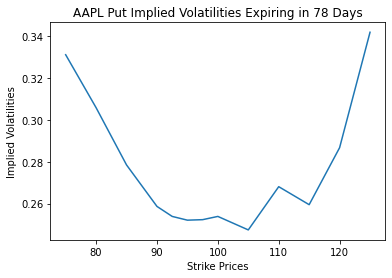

In [33]:
# plot Implied Volatilities
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(strikes, impvols_put)
plt.xlabel('Strike Prices')
plt.ylabel('Implied Volatilities')
plt.title('AAPL Put Implied Volatilities Expiring in 78 Days')
plt.show()